In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import os, glob, shutil, math, time

########################################################################
# This section rescales the data. For most ML models, we want to       #
# rescale so that we are analyzing data consistently (scale invariant) #
########################################################################
def data_rescale(scaled_dat,train_mean,train_var):
    d = np.shape(train_mean)[0]
    #print('unnormalizing with number of dimensions = ' +str(d))
    dat = (np.multiply(scaled_dat,np.sqrt(train_var))) + train_mean.T
    return(dat)
############################################################################
# Opposite to the above, normalizes the data based on some training values #
############################################################################
def data_normalize(data,train_mean,train_var):
    d = np.shape(train_mean)[0]
    print('normalizing with number of dimensions = ' +str(d))
    scaled_dat = np.divide((data - train_mean.T),np.sqrt(train_var),)
    return(scaled_dat)
    


In [2]:
data = pd.read_csv("../Data/QM9/mu-qm-file.csv")

In [3]:
## seed 
np.random.seed(4)
# get random partition
msk = np.random.rand(np.shape(data)[0]) < 0.01


# test and train split
train_data = data[msk]
test_data = data[~msk]

In [4]:
# get 
feature_names=[]
for ft in data.columns:
    if ft.find('u0') ==-1  and ft.find('runs') ==-1 and ft.find('mu') ==-1:
            feature_names.append(ft)
print(feature_names)
# feature_names = ['f-Z-0-all','f-chi-0-all']

['f-chi-0-all', 'f-chi-1-all', 'f-chi-2-all', 'f-chi-3-all', 'f-Z-0-all', 'f-Z-1-all', 'f-Z-2-all', 'f-Z-3-all', 'f-I-0-all', 'f-I-1-all', 'f-I-2-all', 'f-I-3-all', 'f-T-0-all', 'f-T-1-all', 'f-T-2-all', 'f-T-3-all', 'f-S-0-all', 'f-S-1-all', 'f-S-2-all', 'f-S-3-all']


In [5]:
# COFs
train_data_y = train_data['u0']*627.529
test_data_y = test_data['u0']*627.529
# xvales
train_data_x = train_data[feature_names].values
test_data_x = test_data[feature_names].values
## data generation
m = np.shape(train_data_x)[0]
d = np.shape(train_data_x)[1]
p = 1
# normalization
train_var_x = np.var(train_data_x,0)
train_mean_x = np.mean(train_data_x,0).reshape(d,1).squeeze()
train_var_y = np.var(train_data_y,0).reshape(1)
train_mean_y = np.mean(train_data_y,0).reshape(1)
# scale
scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y)
scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)
scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y)

normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1


In [6]:
from sklearn import linear_model

#########################################
# This is just simple linear regression #
#########################################

reg = linear_model.LinearRegression()
reg.fit(scaled_train_data_x,scaled_train_data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
pred_train = data_rescale(reg.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
pred_test = data_rescale(reg.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
def rms(val):
    return(np.sqrt(np.mean(np.power(val,2))))
print('linear model TRAIN error is ' + str(rms(pred_train-real_train))+' kcal/mol')
print('linear model TEST error is ' + str(rms(pred_test-real_test))+' kcal/mol')

linear model TRAIN error is 11.959184829 kcal/mol
linear model TEST error is 12.34449048 kcal/mol


Text(0,0.5,'pred, kcal/mol')

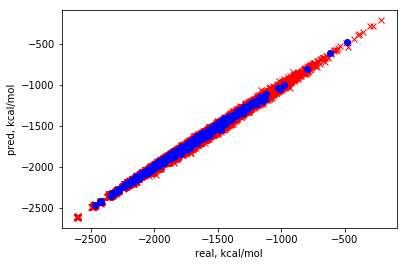

In [8]:
plt.plot(real_test,pred_test,'rx')
plt.plot(real_train,pred_train,'bo')
plt.xlabel('real, kcal/mol')
plt.ylabel('pred, kcal/mol')

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [ ]:
print('In KRR!')
lambdas = np.array([0.001, 0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001])
sigmas = np.array([1,0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])
nus = np.array([1])

tuned_parameters = [{'kernel': ['rbf'], 'gamma': sigmas, 'alpha': lambdas}]
reshapedy = np.squeeze(scaled_train_data_y)

fig, axs = plt.subplots(1,1, facecolor='w', edgecolor='k',squeeze=False)
fig.subplots_adjust(hspace = .3, wspace= 1)
axs = axs.ravel()
clf = GridSearchCV(KernelRidge(), tuned_parameters, cv=10, scoring='neg_mean_absolute_error')
clf.fit(scaled_train_data_x, reshapedy)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

scores = (-(clf.cv_results_['mean_test_score'].reshape(len(lambdas),len(sigmas))))*np.sqrt(train_var_y)
im = axs[0].imshow(scores, interpolation='nearest', cmap=plt.cm.jet)
axs[0].set_xticks(np.arange(len(sigmas)))
axs[0].set_yticks(np.arange(len(lambdas)))
axs[0].set_xticklabels(['{:g}'.format(float('{:.3g}'.format(j))) for j in tuned_parameters[0]['gamma']])
axs[0].set_yticklabels(['{:g}'.format(float('{:.3g}'.format(j))) for j in tuned_parameters[0]['alpha']])
axs[0].set_xlabel('Sigma Value')
axs[0].set_ylabel('Lambda Value')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
cbar = fig.colorbar(im, ax = axs[0], fraction=0.046, pad=0.04)#,boundaries = np.linspace(0.3, 0.8, 21))
cbar.set_label('MAE (kcal/mol)')
fig.suptitle('2D Hyperparameter Grid Search (KRR)')
print('Chosen Alpha: ', clf.best_params_['alpha'])
print('Chosen Gamma: ', clf.best_params_['gamma'])
final_model = KernelRidge(kernel = 'rbf', alpha = clf.best_params_['alpha'], gamma = clf.best_params_['gamma'])


In KRR!


In [81]:
final_model.fit(scaled_train_data_x, scaled_train_data_y)
krr_train = data_rescale(final_model.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
krr_test = data_rescale(final_model.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
print('KRR model TRAIN error is ' + str(rms(krr_train-real_train))+' kcal/mol')
print('KRR model TEST error is ' + str(rms(krr_test-real_test))+' kcal/mol')

KRR model TRAIN error is 11.6570559346 kcal/mol
KRR model TEST error is 12.2813339243 kcal/mol


Text(0,0.5,'pred, kcal/mol')

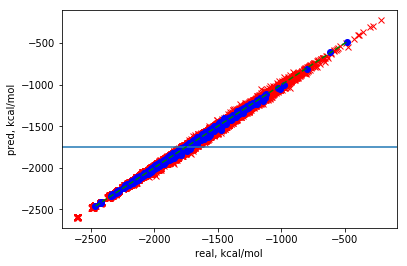

In [84]:
plt.plot(real_test,krr_test,'rx')
plt.plot(real_train,krr_train,'bo')
plt.axhline(y=np.mean(train_data_y))
plt.plot(np.linspace(min(krr_train),max(krr_train)),np.linspace(min(krr_train),max(krr_train)),'g--')
plt.xlabel('real, kcal/mol')
plt.ylabel('pred, kcal/mol')

KRR bad model TRAIN error is 1.97035944038e-08
KRR bad model TEST error is 114.942710323


Text(0,0.5,'pred')

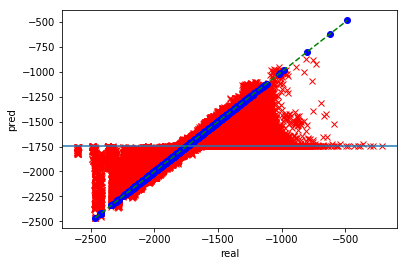

In [85]:
bad_model = KernelRidge(kernel = 'rbf', alpha = 1e-10, gamma = 1)
bad_model.fit(scaled_train_data_x, scaled_train_data_y)
krr_train_bad = data_rescale(bad_model.predict(scaled_train_data_x),train_mean_y,train_var_y)
krr_test_bad = data_rescale(bad_model.predict(scaled_test_data_x),train_mean_y,train_var_y)
print('KRR bad model TRAIN error is ' + str(rms(krr_train_bad-real_train)))
print('KRR bad model TEST error is ' + str(rms(krr_test_bad-real_test)))

# plt.plot(krr_train_bad,pred_train,'bo')
plt.plot(real_test,krr_test_bad,'rx')
plt.plot(real_train,krr_train_bad,'bo')
plt.axhline(y=np.mean(train_data_y))
plt.plot(np.linspace(min(krr_train_bad),max(krr_train_bad)),np.linspace(min(krr_train_bad),max(krr_train_bad)),'g--')
plt.xlabel('real')
plt.ylabel('pred')
# plt.xlim([-2,8])
# plt.ylim([0,10])

In [86]:
np.mean(train_data['u0'])


-2.7862618156297421